In [1]:
from astropy.io import ascii
from scipy.optimize import minimize
from scipy import interpolate

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Fourier function, Eq. 8 in the paper
def function_fourier_fit(a, t):
    
    ret = a[0] + a[1]*np.sin(2*np.pi*(t)) + a[2]*np.cos(2*np.pi*(t))
    i = 0

    for deg in range(3, len(a),2):
        i+=1
        ret += a[deg]*np.sin(2*(i+1)*np.pi*(t)) + a[deg+1]*np.cos(2*(i+1)*np.pi*(t))

    return ret


# Log-normal distribution
def ln_normal(dy, std):
    return -0.5 * (dy)**2 / std**2 - 0.5*np.log(2*np.pi) - np.log(std)

# Data for a given star

In [3]:
# --------- example

time_of_brighness_maxima = 2455197.5 # M0
pulsation_period = 0.33 # per
ampV = 0.4   # amplitude in V-band
eampV = 0.01 # error on amplitude in V-band

class_star = "RRc"

time_of_observations = np.array([2455197.62, 2455197.642]) # JD
line_of_sight_velocity = np.array([-30.6, -27.22]) # vlos
uncertainty_line_of_sight_velocity = np.array([1.44, 2.32]) # evlos

## Amplitude scaling relation

In [4]:
# Equations 9 in the paper
scaling_relation_RRc = np.array([58.0]) 
error_on_scaling_relation_RRc = np.array([2.0]) 

## Template and scatter in template

In [5]:
# Table 3, last row in the table
template_fourier_rrc = np.array([+0.0000, -0.3417, -0.3166, 
                                 -0.1069, -0.0751, -0.0220, 
                                 -0.0424]) 

# Table B4, first column in the table
phase_for_scatter_in_template = np.array([0.000, 0.025, 0.075, 0.125, 
                                          0.175, 0.225, 0.275, 0.325, 
                                          0.375, 0.425, 0.475, 0.525, 
                                          0.575, 0.625, 0.675, 0.725, 
                                          0.775, 0.825, 0.875, 0.925, 
                                          0.975, 1.000])  

# Table B4, last  column in the table
scatter_in_template_rrc = np.array([0.004, 0.004, 0.064, 0.097, 
                                    0.104, 0.077, 0.127, 0.199, 
                                    0.271, 0.121, 0.121, 0.064, 
                                    0.052, 0.068, 0.060, 0.082, 
                                    0.070, 0.094, 0.171, 0.164, 
                                    0.072, 0.072]) 

f_spline_err_rrc = interpolate.interp1d(phase_for_scatter_in_template, scatter_in_template_rrc, kind='linear')

In [6]:
vector = ampV

Amp_line_of_sight_vel = scaling_relation_RRc * vector 
uncertainty_Amp_line_of_sight_vel = np.sqrt(vector * error_on_scaling_relation_RRc * vector 
                                            + (scaling_relation_RRc[0]**2)*(eampV**2) + 3.8**2)

print(r"Predicted amplitude of the line of sight velocity and its error is: %.1f ± %.1f kms-1" %(Amp_line_of_sight_vel, 
                                                                                           uncertainty_Amp_line_of_sight_vel))

Predicted amplitude of the line of sight velocity and its error is: 23.2 ± 3.9 kms-1


In [7]:
def systematic_velocity_determ(param, HJD, measured_velocity, uncertainty_measured_velocity, 
                               P, M0, Alos, eAlos, template_fourier, f_spline_err):
    
    vsys = param

    # Equation 18 in paper    # Equation 16 in paper
    phase_star = np.mod(HJD - M0, P) / P
    
    # Equation 16 in paper
    model_velocity = function_fourier_fit(template_fourier, phase_star)*Alos + vsys

    # Equation 17 in paper
    evel_fin = np.sqrt(uncertainty_measured_velocity**2 
                       + (f_spline_err(phase_star)*Alos)**2 
                       + (function_fourier_fit(template_fourier,phase_star)*eAlos)**2 )

    # Equation 15 in paper
    result = ln_normal(measured_velocity - model_velocity, evel_fin) 

    return np.nansum(result[np.isfinite(result)])


# Possibility for including some priors
def prior(param):
    # pick a prior
    return 0.0

#    
def LOG_probability(param, HJD, measured_velocity, uncertainty_measured_velocity, P, M0, Alos, eAlos, 
                    template_fourier, f_spline_err):
    
    lp = prior(param)
    
    rety = systematic_velocity_determ(param, HJD, measured_velocity, 
                                      uncertainty_measured_velocity, 
                                      P, M0, Alos, eAlos, template_fourier, 
                                      f_spline_err) 

    return lp + rety


def LOG_minus(param, HJD, measured_velocity, uncertainty_measured_velocity, P, M0, Alos, eAlos, template_fourier, f_spline_err):
    return -LOG_probability(param, HJD, measured_velocity, uncertainty_measured_velocity, P, M0, Alos, eAlos, template_fourier, f_spline_err)

## Using Scipy library

In [8]:
p0 = np.array([-20.])

res = minimize(LOG_minus, x0=p0, args=(time_of_observations, 
                                      line_of_sight_velocity, 
                                      uncertainty_line_of_sight_velocity, 
                                      pulsation_period, 
                                      time_of_brighness_maxima, 
                                      Amp_line_of_sight_vel, 
                                      uncertainty_Amp_line_of_sight_vel, 
                                      template_fourier_rrc, 
                                      f_spline_err_rrc), method='BFGS') #SLSQP


print("Determined systemic velocity and its uncertainty is: %.1f ± %.1f kms-1" %(res.x[0], np.sqrt(np.diag(res.hess_inv))[0]))

Determined systemic velocity and its uncertainty is: -31.0 ± 3.2 kms-1


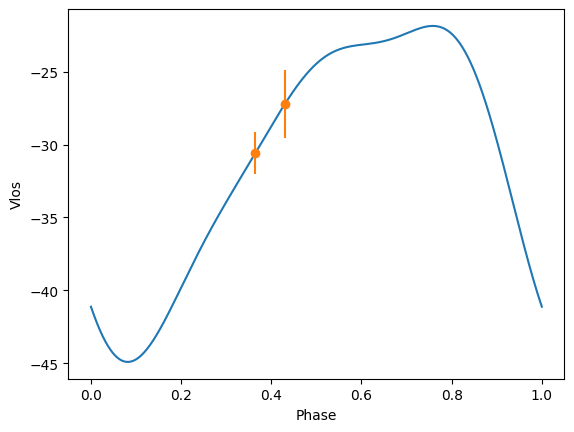

In [9]:
phase_star = np.mod(time_of_observations - time_of_brighness_maxima, pulsation_period) / pulsation_period

phase_star_model = np.linspace(0, 1, 1000)

model_velocity_rrab1 = function_fourier_fit(template_fourier_rrc, phase_star_model)*Amp_line_of_sight_vel + res.x[0]

plt.plot(phase_star_model, model_velocity_rrab1)
plt.errorbar(phase_star, line_of_sight_velocity, yerr=uncertainty_line_of_sight_velocity, fmt="o")
plt.xlabel("Phase")
plt.ylabel("Vlos")
plt.show()